In [3]:
import numpy as np

def predict_next_state(user_data):
    """
    Predicts the next state based on the current state using a simple linear model.
    
    Args:
    - user_data: numpy array of shape (n, 6), where n is the number of timesteps,
                 and 6 represents the 6 DoF (x, y, z, yaw, pitch, roll).
    
    Returns:
    - next_state: numpy array of shape (6,), representing the predicted next state.
    """
    # For a truncated model, we'll use the most recent two states
    if user_data.shape[0] < 2:
        raise ValueError("Not enough data for prediction.")
    
    # Calculate the difference between the last two states
    delta = user_data[-1] - user_data[-2]
    
    # Predict the next state by adding the delta to the last state
    next_state = user_data[-1] + delta
    
    return next_state

# Example usage
# Assuming user_data is a numpy array with your 6DoF data for user1
# Shape of user_data should be (n, 6), where n is the number of timesteps
# Here's a dummy example of user_data for demonstration purposes
user_data = np.array([
    [1, 1, 1, 0, 0, 0],  # First state
    [2, 2, 2, 0.1, 0.1, 0.1],  # Second state
    # Add more states as needed
])

next_state = predict_next_state(user_data)
print("Predicted next state:", next_state)


Predicted next state: [3.  3.  3.  0.2 0.2 0.2]


In [132]:
# 34%360

34

In [72]:
import numpy as np

def linear_regression(x, y):
    """
    Computes the coefficients of a linear regression y = mx + c using least squares.
    
    Args:
    - x: numpy array of shape (n,), the independent variable
    - y: numpy array of shape (n,), the dependent variable
    
    Returns:
    - m: Slope of the fitted line
    - c: Intercept of the fitted line
    """
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def predict_next_state_tlp(user_data, window_size=2,dof=6,future_steps = 1):
    """
    Predicts the next state based on the last 'window_size' states using linear regression.
    
    Args:
    - user_data: numpy array of shape (n, 6), where n is the number of timesteps,
                 and 6 represents the 6 DoF (x, y, z, yaw, pitch, roll).
    - window_size: int, the number of states to consider for the prediction
    
    Returns:
    - next_state: numpy array of shape (6,), representing the predicted next state.
    """
    if user_data.shape[0] < window_size:
        raise ValueError("Not enough data for prediction.")
    
    next_state = np.zeros(dof)
    time_steps = np.arange(window_size)
    
    # Perform linear regression on each DoF using the last 'window_size' states
    for i in range(dof):
        m, c = linear_regression(time_steps, user_data[-window_size:, i])
        next_state[i] = m * (window_size+future_steps-1) + c  # Predict the next state
    
    return next_state

def predict_next_state_tlp_rad(user_data, window_size=2,dof=6,future_steps = 1):
    """
    Predicts the next state based on the last 'window_size' states using linear regression.
    
    Args:
    - user_data: numpy array of shape (n, 6), where n is the number of timesteps,
                 and 6 represents the 6 DoF (x, y, z, yaw, pitch, roll).
    - window_size: int, the number of states to consider for the prediction
    
    Returns:
    - next_state: numpy array of shape (6,), representing the predicted next state.
    """
    if user_data.shape[0] < window_size:
        raise ValueError("Not enough data for prediction.")
    
    next_state = np.zeros(dof)
    time_steps = np.arange(window_size)
    
    # Perform linear regression on each DoF using the last 'window_size' states
    # for i in range(dof):
    #     m, c = linear_regression(time_steps, user_data[-window_size:, i])
    #     next_state[i] = (m * (window_size+future_steps-1) + c +360)%360  # Predict the next state
    for i in range(dof):
        # Convert the data to radians
        rad_data = np.deg2rad(user_data[-window_size:, i])
        
        # Convert the data to sine and cosine values
        sin_data = np.sin(rad_data)
        cos_data = np.cos(rad_data)
        
        # Apply linear regression to the sine and cosine values
        m_sin, c_sin = linear_regression(time_steps, sin_data)
        m_cos, c_cos = linear_regression(time_steps, cos_data)
        
        # Predict the next state
        next_sin = m_sin * (window_size + future_steps - 1) + c_sin
        next_cos = m_cos * (window_size + future_steps - 1) + c_cos
        
        # Convert the sine and cosine values back to an angle in radians
        next_rad = np.arctan2(next_sin, next_cos)
        
        # Convert the angle to degrees and adjust the range to [0, 360)
        next_state[i] = (np.rad2deg(next_rad) + 360) % 360
    
    return next_state

# Example usage
# Assuming user_data is a numpy array with your 6DoF data for user1
dof = 2
user_data = np.random.rand(10, dof)  # Dummy data for demonstration

next_state = predict_next_state_tlp(user_data, window_size=3,dof=dof)
print("Predicted next state using the last 30 states:", next_state)


Predicted next state using the last 30 states: [-0.02171546  0.12600739]


# LR prediction

In [73]:
# read ground truth data
from node_feature_utils import parse_trajectory_data
import matplotlib.pyplot as plt
file_path = "../point_cloud_data/6DoF-HMD-UserNavigationData-master/NavigationData/H4_nav.csv"
trajectory_positions, trajectory_orientations = parse_trajectory_data(file_path,user_index='P01_V1')
print(trajectory_positions.shape)

begin_frame_index = 0
end_frame_index = trajectory_positions.shape[0]-1
# end_frame_index = 120
window_size_lr = 5
future_steps =5
dof = 3
predicted_trajectory_positions = np.zeros(trajectory_positions[begin_frame_index:end_frame_index+1,:].shape)
predicted_trajectory_orientations = np.zeros(trajectory_orientations[begin_frame_index:end_frame_index+1,:].shape)
for frame_index in range(begin_frame_index+window_size_lr,end_frame_index+1 -future_steps +1):
    future_state = predict_next_state_tlp(trajectory_positions[frame_index-window_size_lr:frame_index,:], window_size=window_size_lr,dof=dof,future_steps=future_steps)
    # print(trajectory_positions[frame_index-window_size_lr:frame_index,:])
    # print(next_state)
    
    predicted_trajectory_positions[frame_index+future_steps -1] = future_state
    # import pdb;pdb.set_trace()
    
    future_state = predict_next_state_tlp_rad(trajectory_orientations[frame_index-window_size_lr:frame_index,:], window_size=window_size_lr,dof=dof,future_steps=1)
    # print(trajectory_positions[frame_index-window_size_lr:frame_index,:])
    # print(next_state)
    predicted_trajectory_orientations[frame_index+future_steps -1] = future_state
    
    
    

(212, 3)


In [74]:
predicted_trajectory_positions.shape
# predicted_trajectory_positions[frame_index:frame_index+window_size_lr]

(212, 3)

In [75]:
# trajectory_positions[0:300,:]
# predicted_trajectory_positions

# read gt

In [76]:
file_path = "../point_cloud_data/6DoF-HMD-UserNavigationData-master/NavigationData/H4_nav.csv"
pred_file_path = "../point_cloud_data/LR_pred/H4_nav_pred"+str(window_size_lr)+str(future_steps)+".csv"

In [77]:
import pandas as pd
gt_df = pd.read_csv(file_path)
# get Particiapnt == P01_V1
gt_df = gt_df[gt_df['Participant'] == 'P01_V1']
# df = gt_df.head(end_frame_index+1)
# df = gt_df
gt_df
# save gt data
gt_file_path = "../point_cloud_data/LR_pred/H4_nav_gt.csv"
gt_df.to_csv(gt_file_path,index=False)

# wirte into new predicted trajectory file

In [78]:
# initialize df as gt_df copy
df = gt_df.copy()
df.iloc[0:end_frame_index+1,1:4] = predicted_trajectory_positions
df.iloc[0:end_frame_index+1,4:7] = predicted_trajectory_orientations
df_pred = df
df_pred

,FrameNumber,HMDPX,HMDPY,HMDPZ,HMDRX,HMDRY,HMDRZ,Participant,Dataset,ViewFrame
0,1,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,P01_V1,H4,1
1,2,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,P01_V1,H4,2
2,3,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,P01_V1,H4,3
3,4,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,P01_V1,H4,4
4,5,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,P01_V1,H4,5
...,...,...,...,...,...,...,...,...,...,...
207,58,-0.00945,1.78670,-0.89238,11.168700,356.510321,1.039216,P01_V1,H4,208
208,59,-0.01490,1.78198,-0.89014,10.403409,355.932192,1.396637,P01_V1,H4,209
209,60,-0.02165,1.77764,-0.89118,10.334745,355.334480,1.395571,P01_V1,H4,210
210,61,-0.02725,1.77557,-0.89230,10.526997,354.889947,1.200272,P01_V1,H4,211


In [79]:
# get the difference between the predicted and ground truth data
diff = df_pred.iloc[0:end_frame_index+1,1:7] - gt_df.iloc[0:end_frame_index+1,1:7]
# write the difference to a file
diff_file_path = "../point_cloud_data/LR_pred/H4_nav_diff"+str(window_size_lr)+str(future_steps)+".csv"
diff.to_csv(diff_file_path, index=False)


In [80]:
df_pred.to_csv(pred_file_path,index=False)

# get FoV and calculate loss

In [629]:
%run node_feature_utils.py
cell2node,node2cell = cell2node2cell()

In [630]:
%run node_feature_utils.py
trajectory_positions_pred, trajectory_orientations_pred = parse_trajectory_data(pred_file_path,user_index='P01_V1')

In [631]:
len(trajectory_positions_pred)
# trajectory_positions_pred

121

## get all cell occupied 

In [632]:
occupied_cell_pred = get_all_cell_occupied(frame_index_off_set = 1051,
                                      frame_index_begin = 0,frame_index_end = end_frame_index)
len(occupied_cell_pred)
# occupied_cell

121

## get all cell in the view frustum

In [633]:
# %run node_feature_utils.py
FoV_cell_pred = get_cell_in_view_frustum(trajectory_positions_pred,trajectory_orientations_pred, occupied_cell_pred)
len(FoV_cell_pred)

32

In [634]:
FoV_cell_pred.keys()
# len(FoV_cell.keys())
len(FoV_cell[110])

194

## get feature for all cell

In [635]:
%run node_feature_utils.py
node_occlusion_feature_df_pred = get_occlusion_feature_for_all_cell(FoV_cell_pred,occupied_cell_pred,
                                                               trajectory_positions_pred,
                                                               trajectory_orientations_pred,
                                                               trajectory_frame_index_begin=window_size_lr+future_steps-1,
                                                               trajectory_frame_index_end=end_frame_index)

In [636]:
end_frame_index
len(FoV_cell_pred[110])

186

In [637]:
node_occlusion_feature_df_pred

,cell,ts,label
0,"(7, 1, 8)",89,0.000000
1,"(6, 7, 6)",89,1.000000
2,"(7, 3, 5)",89,0.000000
3,"(7, 12, 8)",89,0.136974
4,"(8, 6, 9)",89,0.096739
...,...,...,...
6740,"(7, 7, 9)",120,0.283098
6741,"(6, 13, 7)",120,0.888569
6742,"(8, 12, 10)",120,0.029437
6743,"(8, 2, 9)",120,0.064441


# load ground truth trajetory and get ground truth for node features

In [638]:
file_path = "./6DoF-HMD-UserNavigationData-master/NavigationData/H1_nav.csv"
trajectory_positions, trajectory_orientations = parse_trajectory_data(file_path,user_index='P01_V1')
trajectory_positions = trajectory_positions[0:end_frame_index+1,:]
trajectory_orientations = trajectory_orientations[0:end_frame_index+1,:]
occupied_cell = get_all_cell_occupied(frame_index_off_set = 1051,
                                      frame_index_begin = 0,frame_index_end = end_frame_index)
# occupied_cell
# %run node_feature_utils.py
FoV_cell = get_cell_in_view_frustum(trajectory_positions,trajectory_orientations, occupied_cell)
# %run node_feature_utils.py
node_occlusion_feature_df = get_occlusion_feature_for_all_cell(FoV_cell,occupied_cell,trajectory_positions,trajectory_orientations,
                              trajectory_frame_index_begin=window_size_lr+future_steps-1,trajectory_frame_index_end=end_frame_index)

In [639]:
node_occlusion_feature_df

,cell,ts,label
0,"(7, 1, 8)",89,0.000000
1,"(6, 7, 6)",89,1.000000
2,"(7, 3, 5)",89,0.000000
3,"(7, 12, 8)",89,0.136974
4,"(8, 6, 9)",89,0.096739
...,...,...,...
6740,"(7, 7, 9)",120,0.283098
6741,"(6, 13, 7)",120,0.888569
6742,"(8, 12, 10)",120,0.029437
6743,"(8, 2, 9)",120,0.064441


# calculate mse loss

In [640]:

# Merging DataFrames on 'u', 'i', 'ts'
joined_df = pd.merge( node_occlusion_feature_df, node_occlusion_feature_df_pred, on=['cell', 'ts'], suffixes=('_gt','_pred'))
# Fill NaN values in label_pred with 4
# joined_df['label_pred'].fillna(4, inplace=True)
joined_df

,cell,ts,label_gt,label_pred
0,"(7, 1, 8)",89,0.000000,0.000000
1,"(6, 7, 6)",89,1.000000,1.000000
2,"(7, 3, 5)",89,0.000000,0.000000
3,"(7, 12, 8)",89,0.136974,0.136974
4,"(8, 6, 9)",89,0.096739,0.096739
...,...,...,...,...
6740,"(7, 7, 9)",120,0.283098,0.283098
6741,"(6, 13, 7)",120,0.888569,0.888569
6742,"(8, 12, 10)",120,0.029437,0.029437
6743,"(8, 2, 9)",120,0.064441,0.064441


In [641]:
joined_df.head(-100)

,cell,ts,label_gt,label_pred
0,"(7, 1, 8)",89,0.000000e+00,0.000000e+00
1,"(6, 7, 6)",89,1.000000e+00,1.000000e+00
2,"(7, 3, 5)",89,0.000000e+00,0.000000e+00
3,"(7, 12, 8)",89,1.369737e-01,1.369737e-01
4,"(8, 6, 9)",89,9.673858e-02,9.673858e-02
...,...,...,...,...
6640,"(7, 4, 7)",120,4.967428e-01,4.967428e-01
6641,"(8, 9, 8)",120,7.095250e-02,7.095250e-02
6642,"(7, 8, 7)",120,2.430194e-20,3.979860e-18
6643,"(7, 9, 6)",120,5.491406e-01,5.491406e-01


In [642]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# Calculating MSE between the 'label' columns
mse = mean_squared_error(joined_df['label_pred'], joined_df['label_gt'])
rmse = sqrt(mse)
rmse

0.2079187839642544

In [643]:
joined_df['label'] = joined_df.label_pred-joined_df.label_gt


In [644]:
# sorted(joined_df.label_pred-joined_df.label_gt)

count    6745.000000
mean        0.017406
std         0.207204
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64


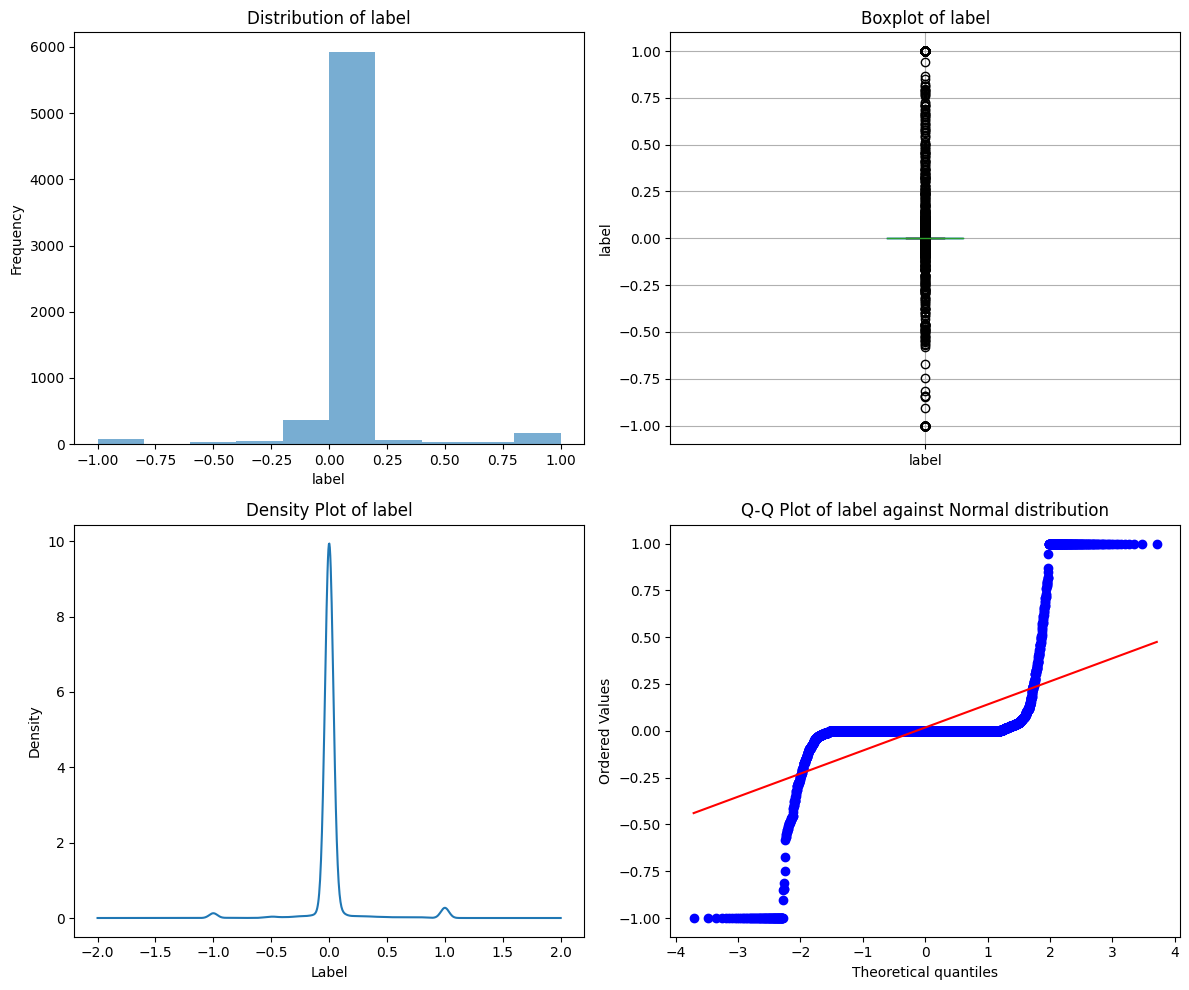

In [645]:
%run node_feature_utils.py
cell_occlusion_level_distribution(joined_df,label='label')

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rmse 0.04379515099162306 window size 5 future steps 1
count    7069.000000
mean       -0.000295
std         0.043797
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64


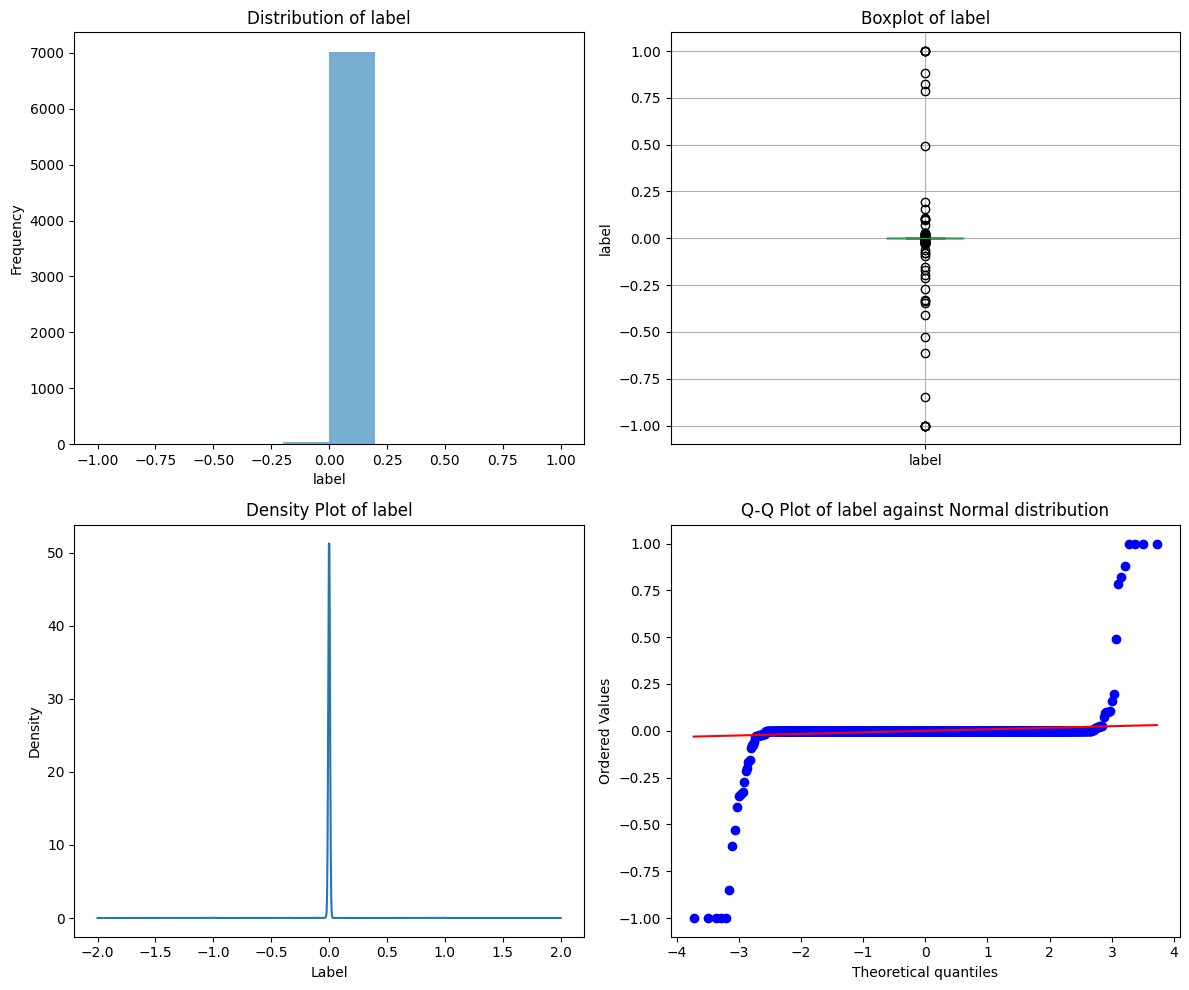

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rmse 0.06525550301655146 window size 5 future steps 2
count    6871.000000
mean       -0.002571
std         0.065210
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64


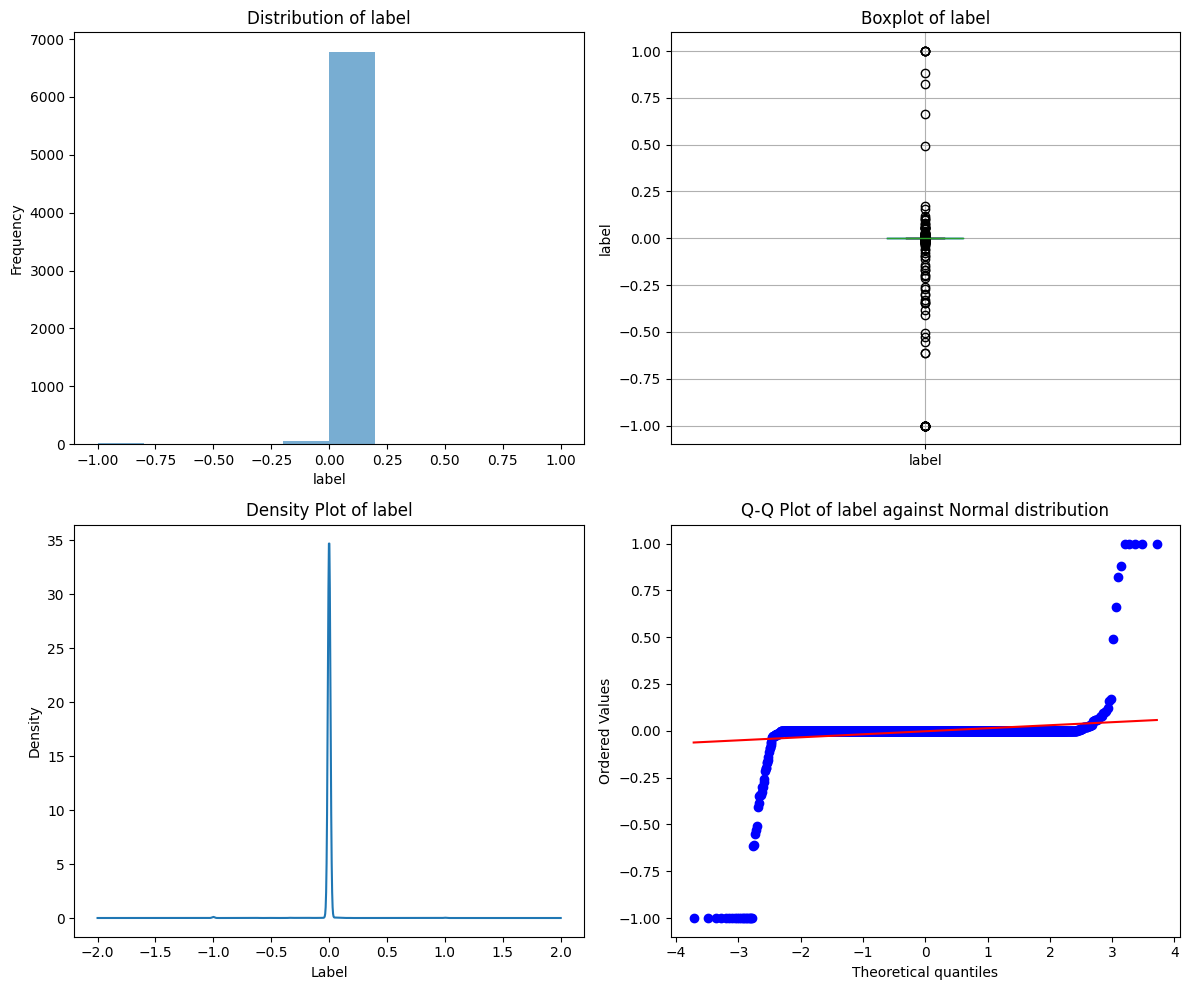

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rmse 0.08123231605321327 window size 5 future steps 3
count    6670.000000
mean       -0.004758
std         0.081099
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64


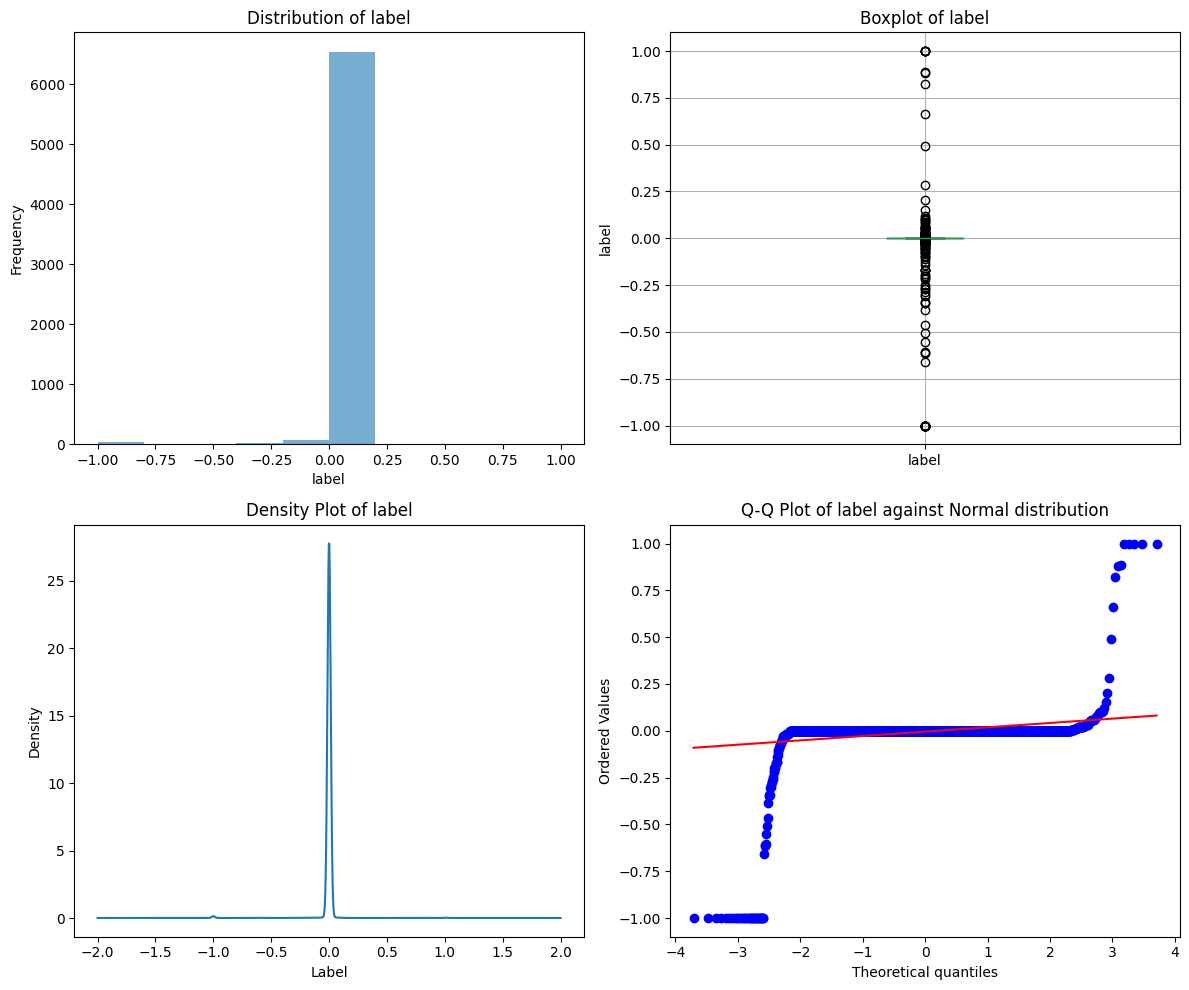

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rmse 0.09360680993637573 window size 5 future steps 4
count    6474.000000
mean       -0.007089
std         0.093345
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64


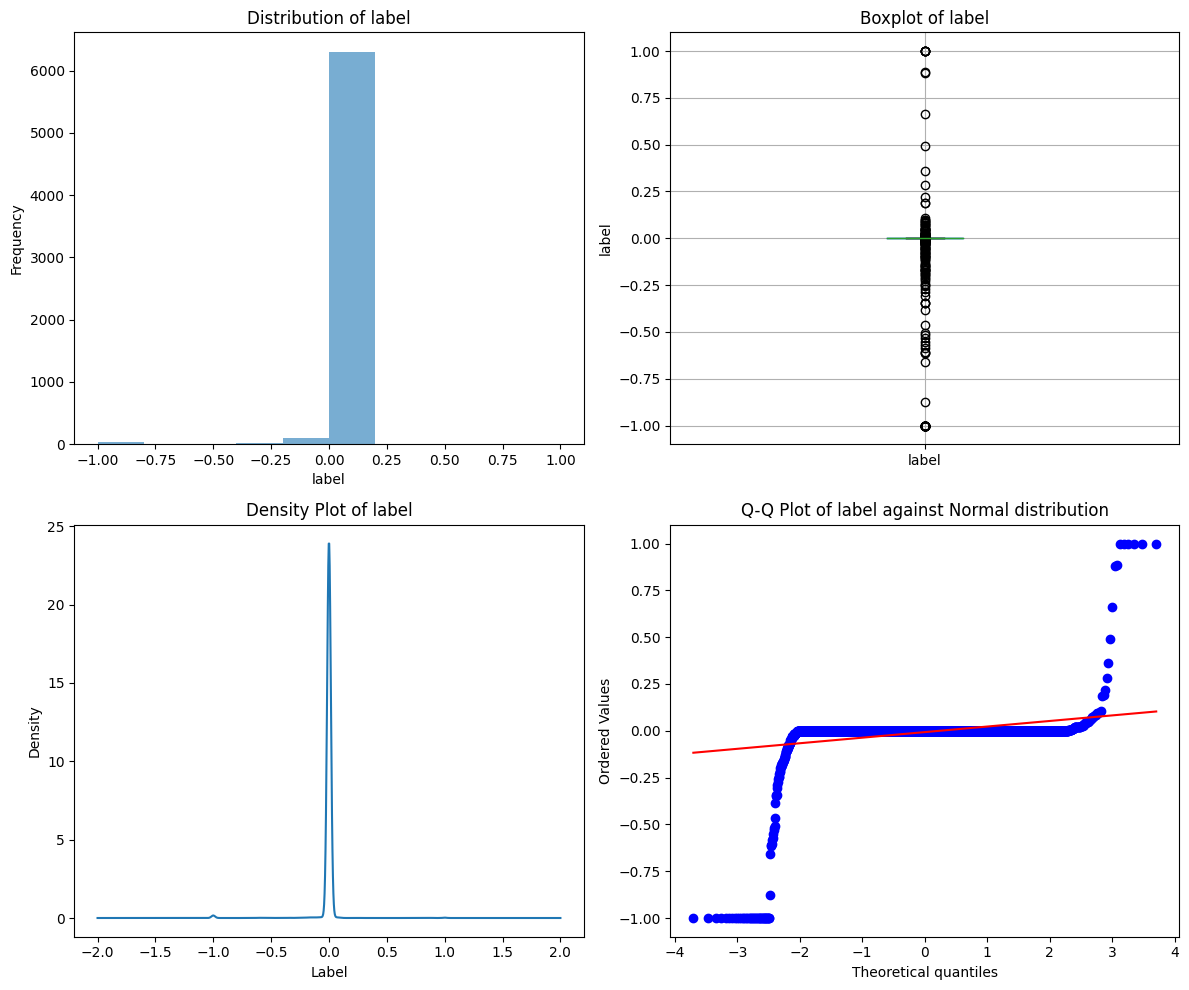

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rmse 0.10618726183845063 window size 5 future steps 5
count    6279.000000
mean       -0.010209
std         0.105704
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64


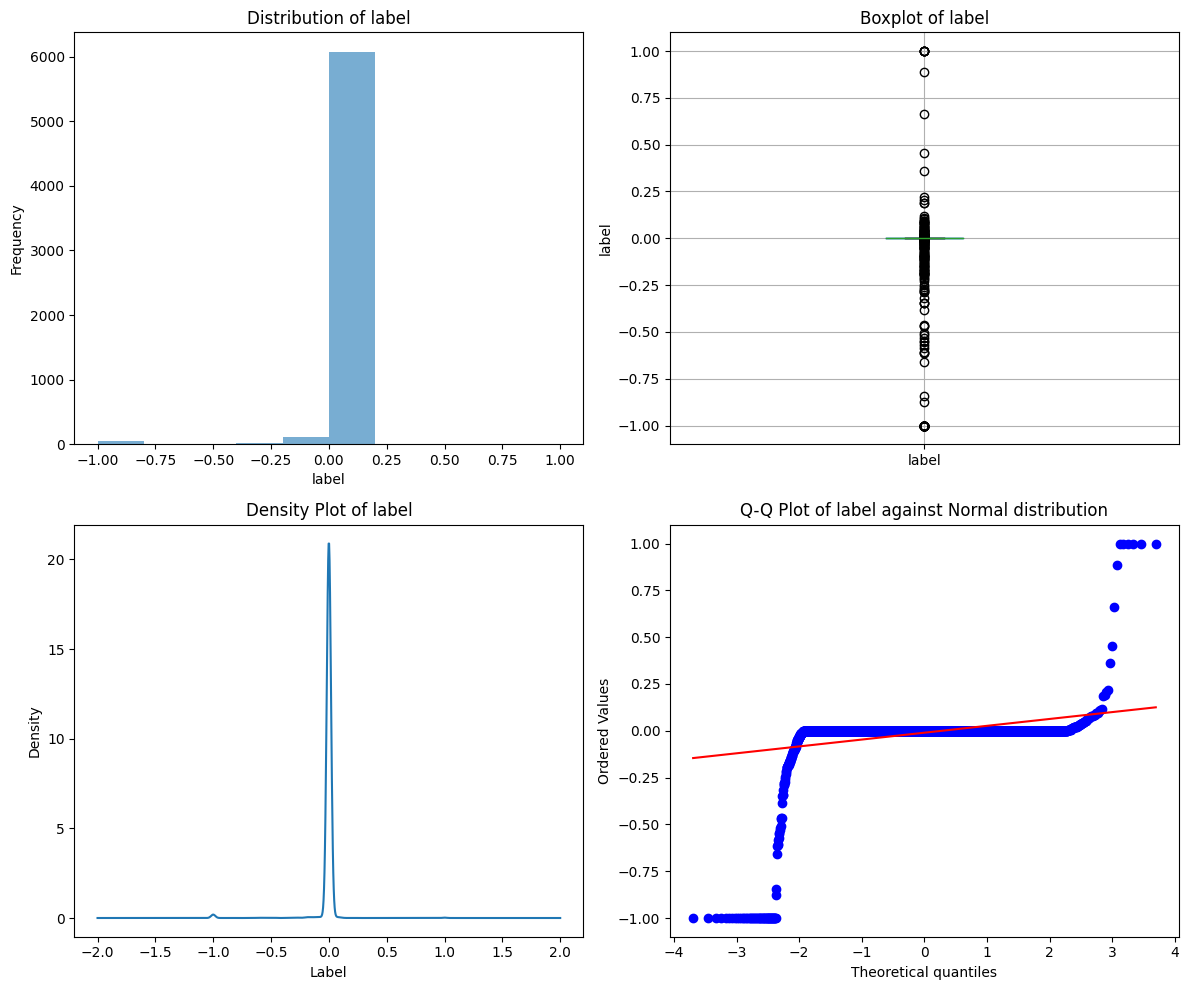

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rmse 0.11750073580199603 window size 5 future steps 6
count    6090.000000
mean       -0.012972
std         0.116792
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64


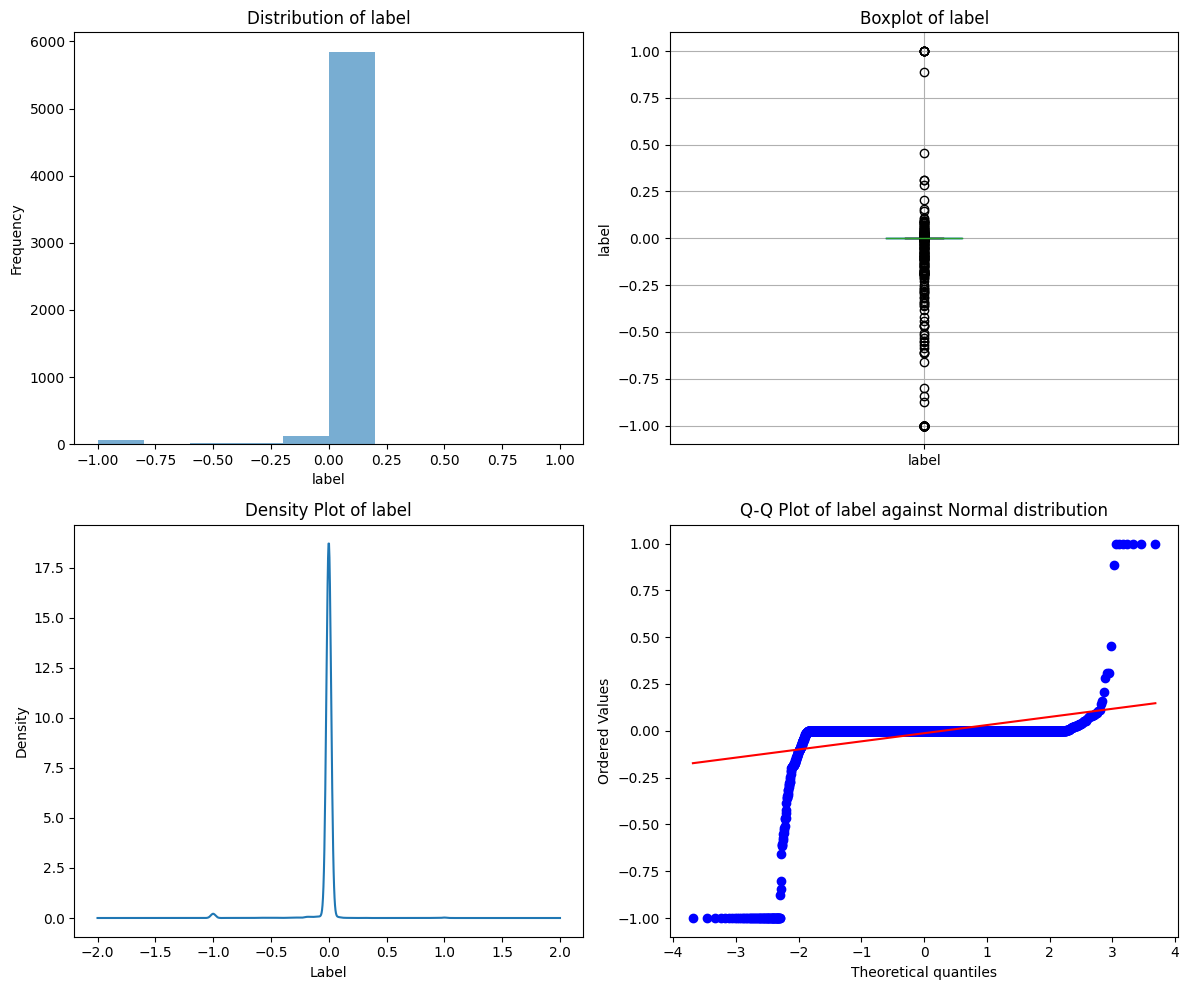

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rmse 0.12799364764432897 window size 5 future steps 7
count    5894.000000
mean       -0.015967
std         0.127005
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64


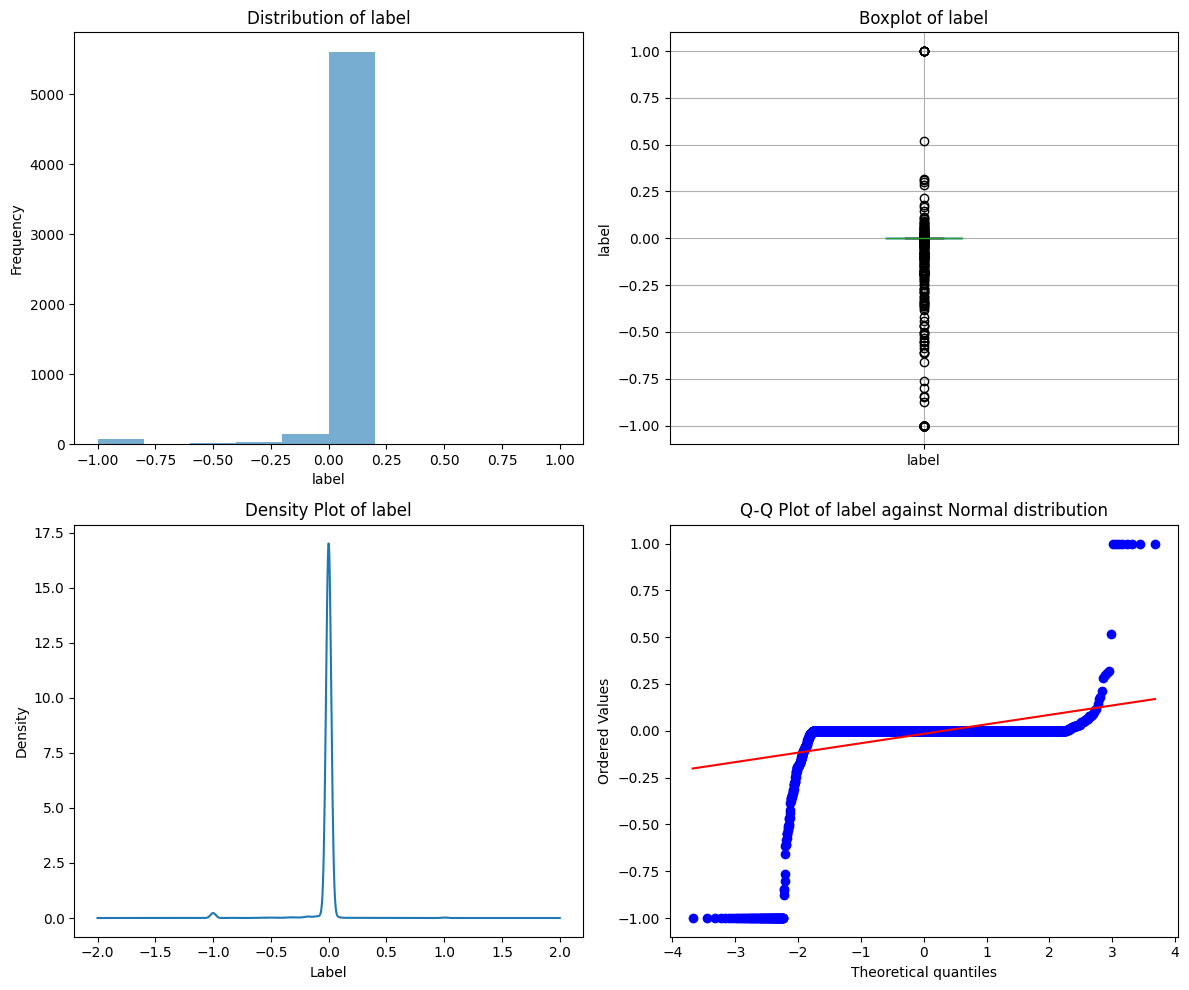

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rmse 0.1377761158391552 window size 5 future steps 8
count    5703.000000
mean       -0.019359
std         0.136421
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64


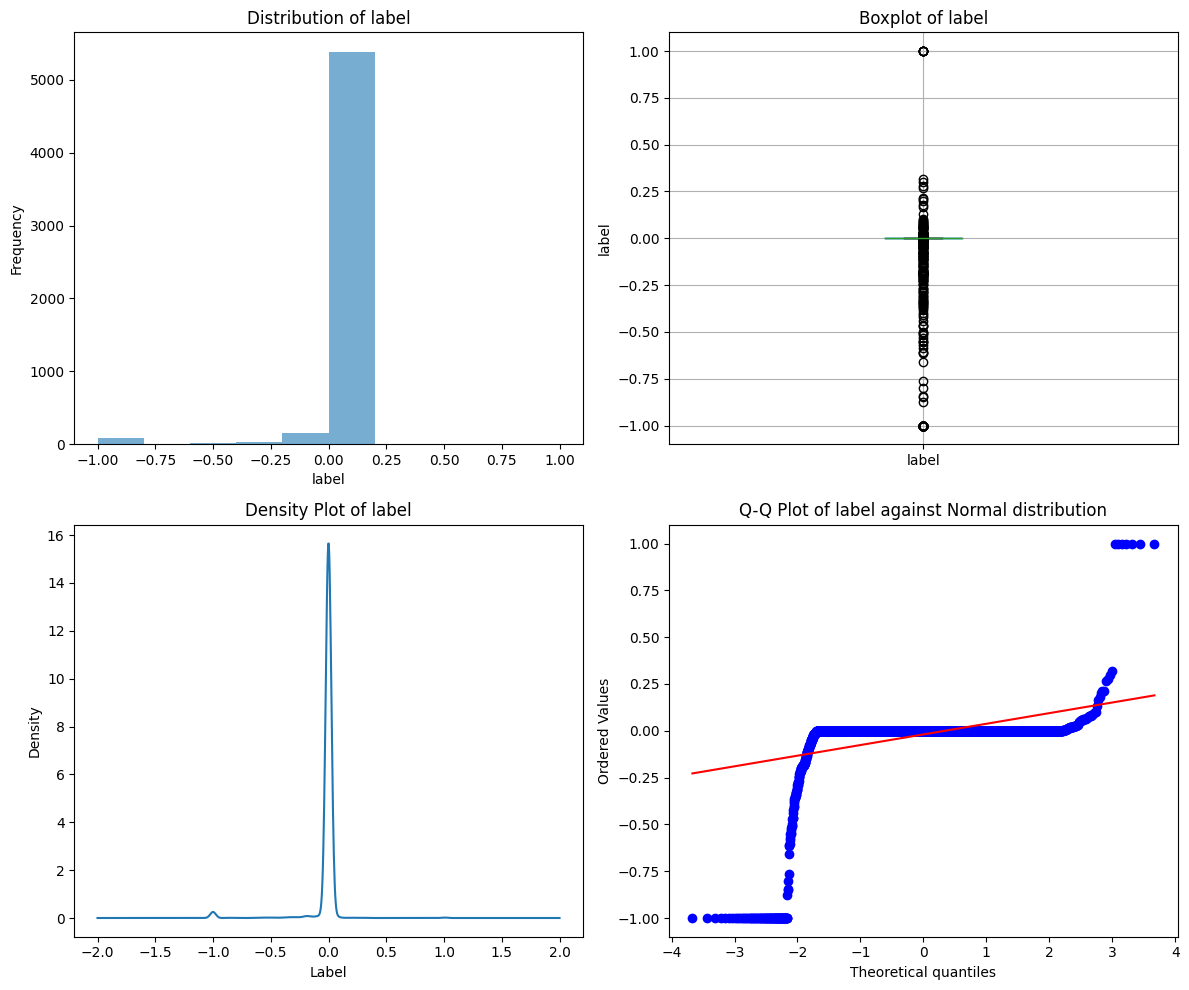

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rmse 0.1461522072939143 window size 5 future steps 9
count    5516.000000
mean       -0.022723
std         0.144388
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64


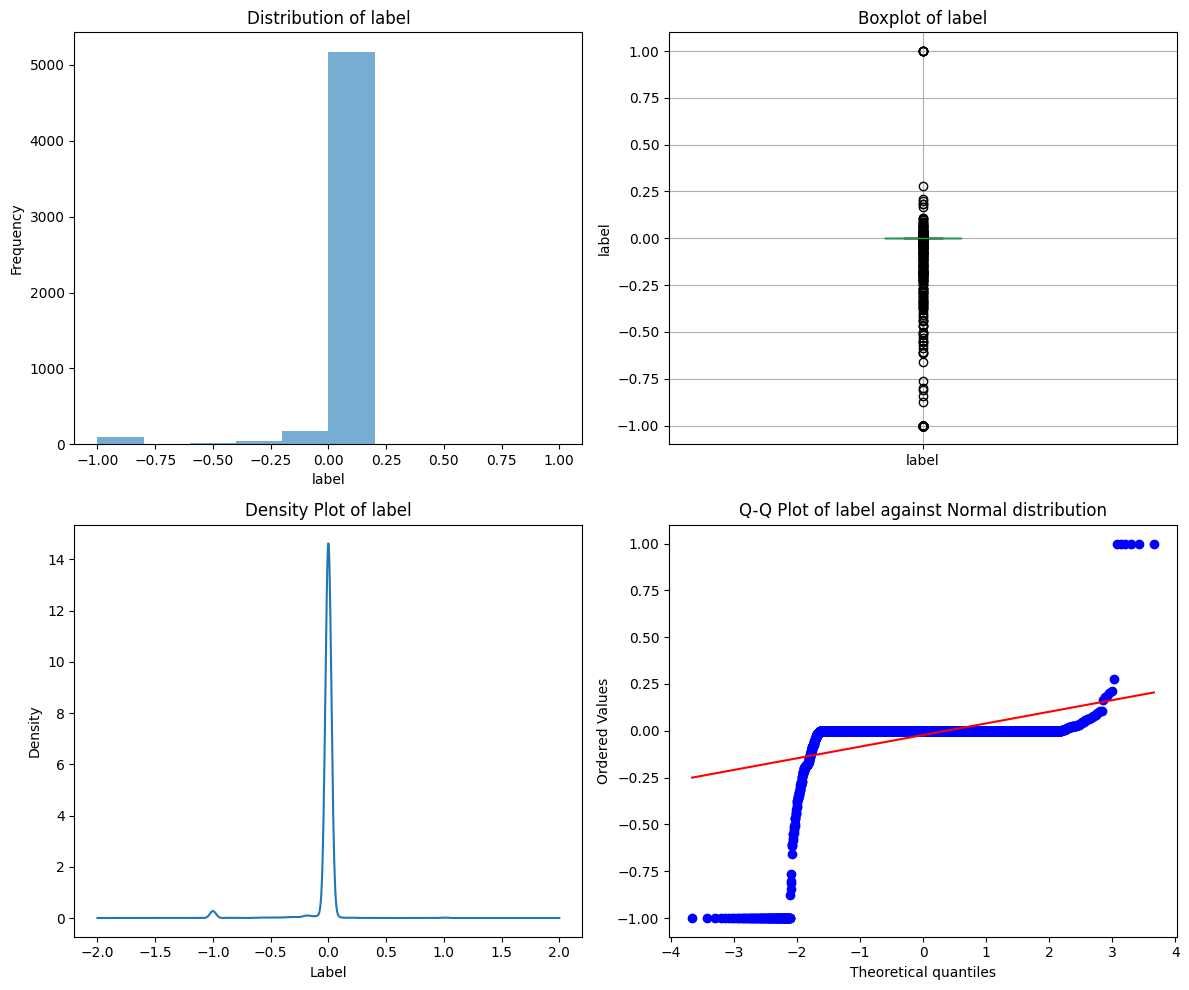

In [647]:
%run node_feature_utils.py
for future_steps in range(1,10):
    LR_prediction(window_size_lr=5,future_steps=future_steps)

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,1:4] = predicted_trajectory_positions
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,4:7] = predicted_trajectory_orientations


10000
20000
10000
20000
rmse 0.09643751556557983 window size 5 future steps 1
count    29493.000000
mean        -0.010666
std          0.095848
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


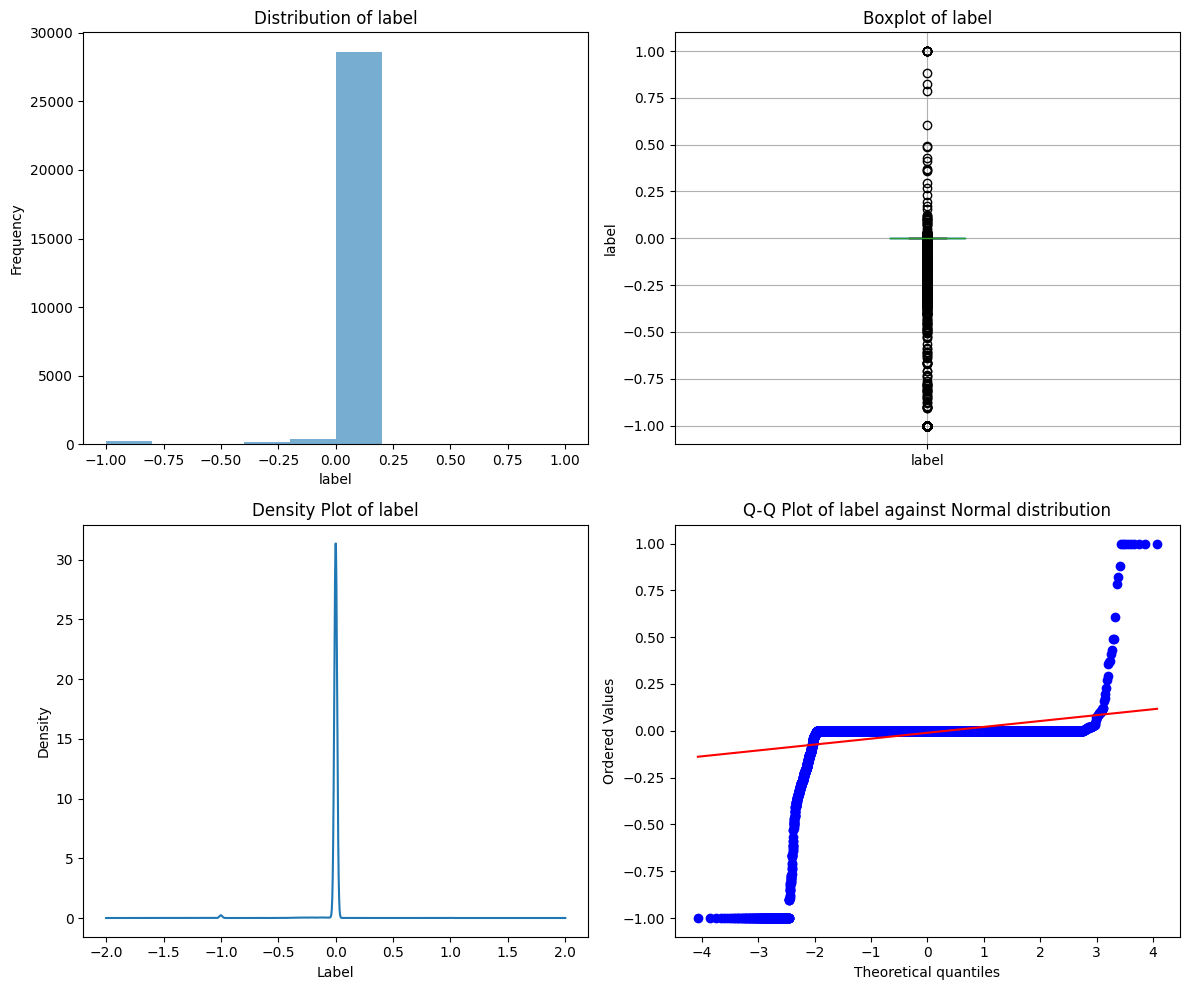

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,1:4] = predicted_trajectory_positions
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,4:7] = predicted_trajectory_orientations


10000
20000
10000
20000
rmse 0.1570052410664616 window size 5 future steps 11
count    27548.000000
mean        -0.016672
std          0.156120
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


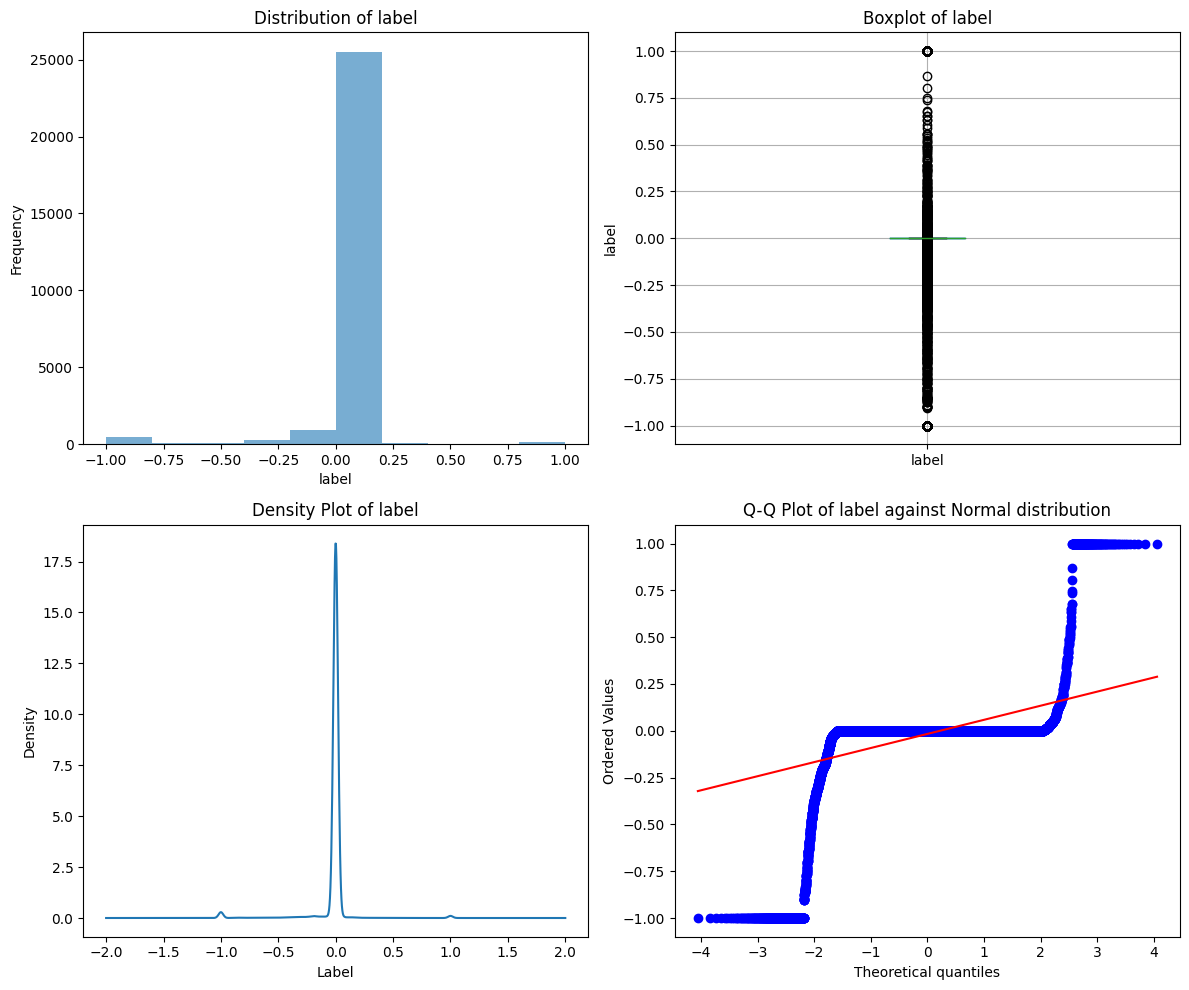

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,1:4] = predicted_trajectory_positions
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,4:7] = predicted_trajectory_orientations


10000
20000
10000
20000
rmse 0.19950055770350747 window size 5 future steps 21
count    25594.000000
mean        -0.022370
std          0.198246
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


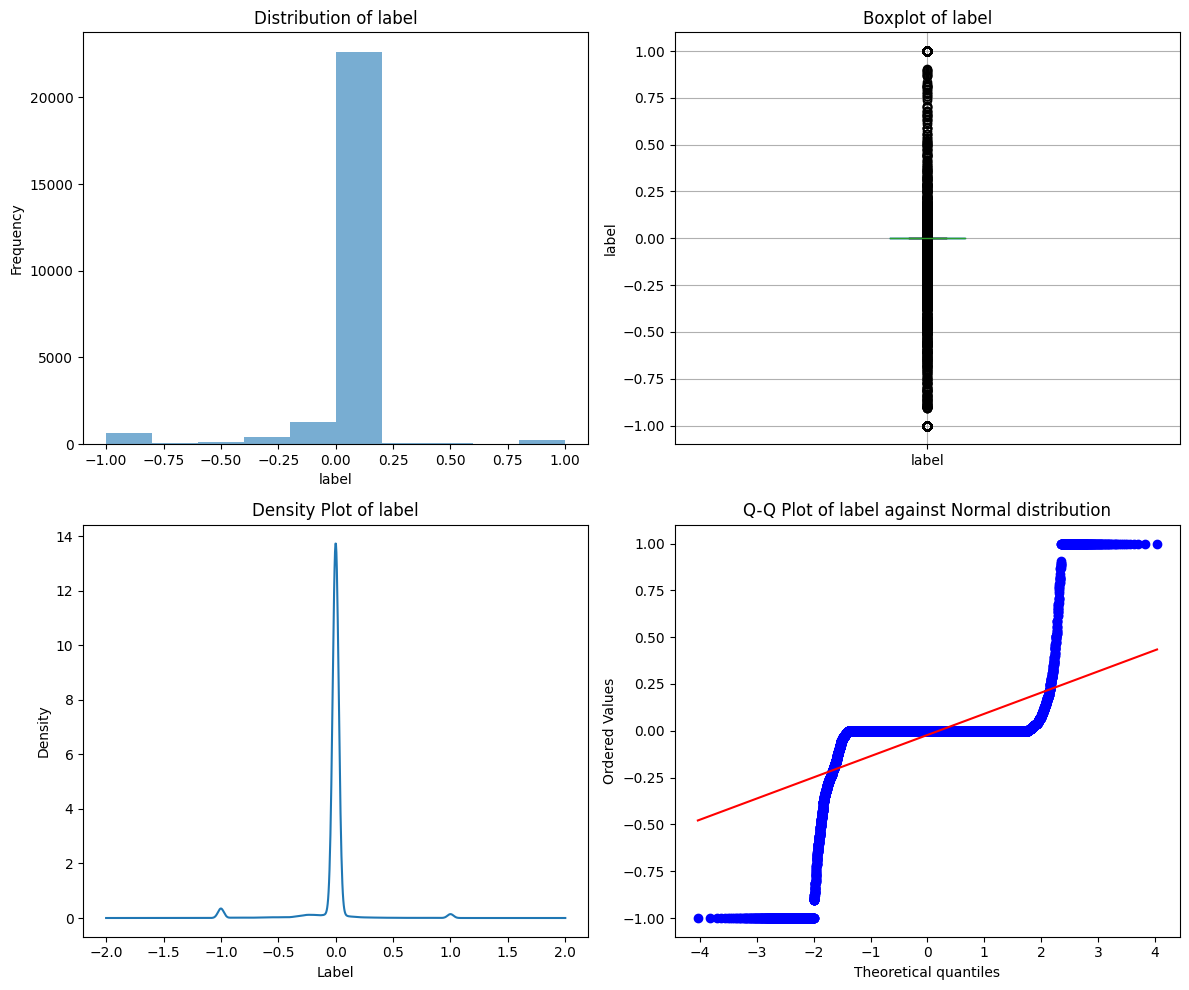

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,1:4] = predicted_trajectory_positions
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,4:7] = predicted_trajectory_orientations


10000
20000
10000
20000
rmse 0.22505622137262193 window size 5 future steps 31
count    23643.000000
mean        -0.027386
std          0.223389
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


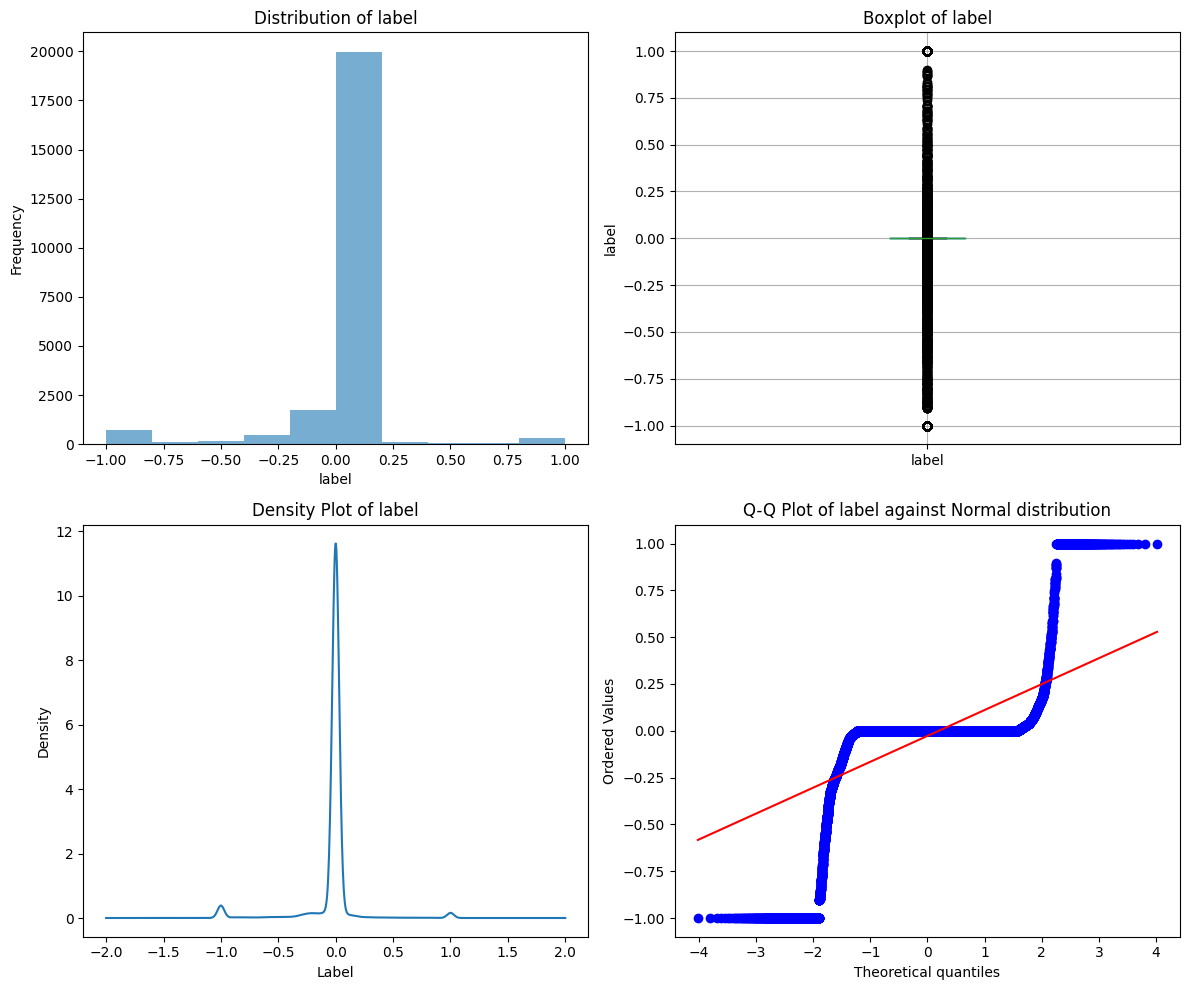

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,1:4] = predicted_trajectory_positions
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,4:7] = predicted_trajectory_orientations


10000
20000
10000
20000
rmse 0.24124464775412946 window size 5 future steps 41
count    21626.000000
mean        -0.030175
std          0.239356
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


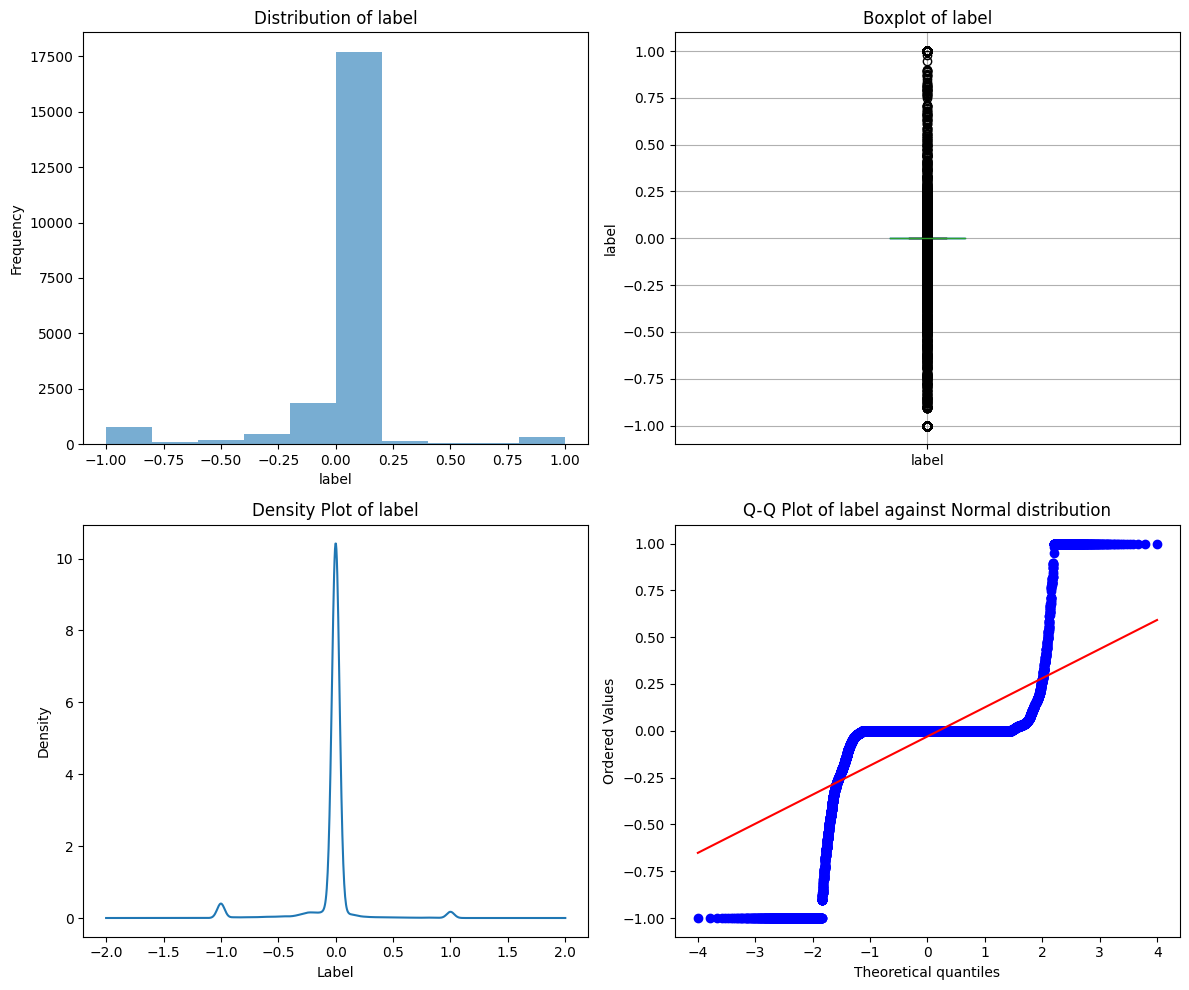

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,1:4] = predicted_trajectory_positions
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,4:7] = predicted_trajectory_orientations


10000
10000
rmse 0.23629481355869775 window size 5 future steps 51
count    19623.000000
mean        -0.029307
std          0.234476
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


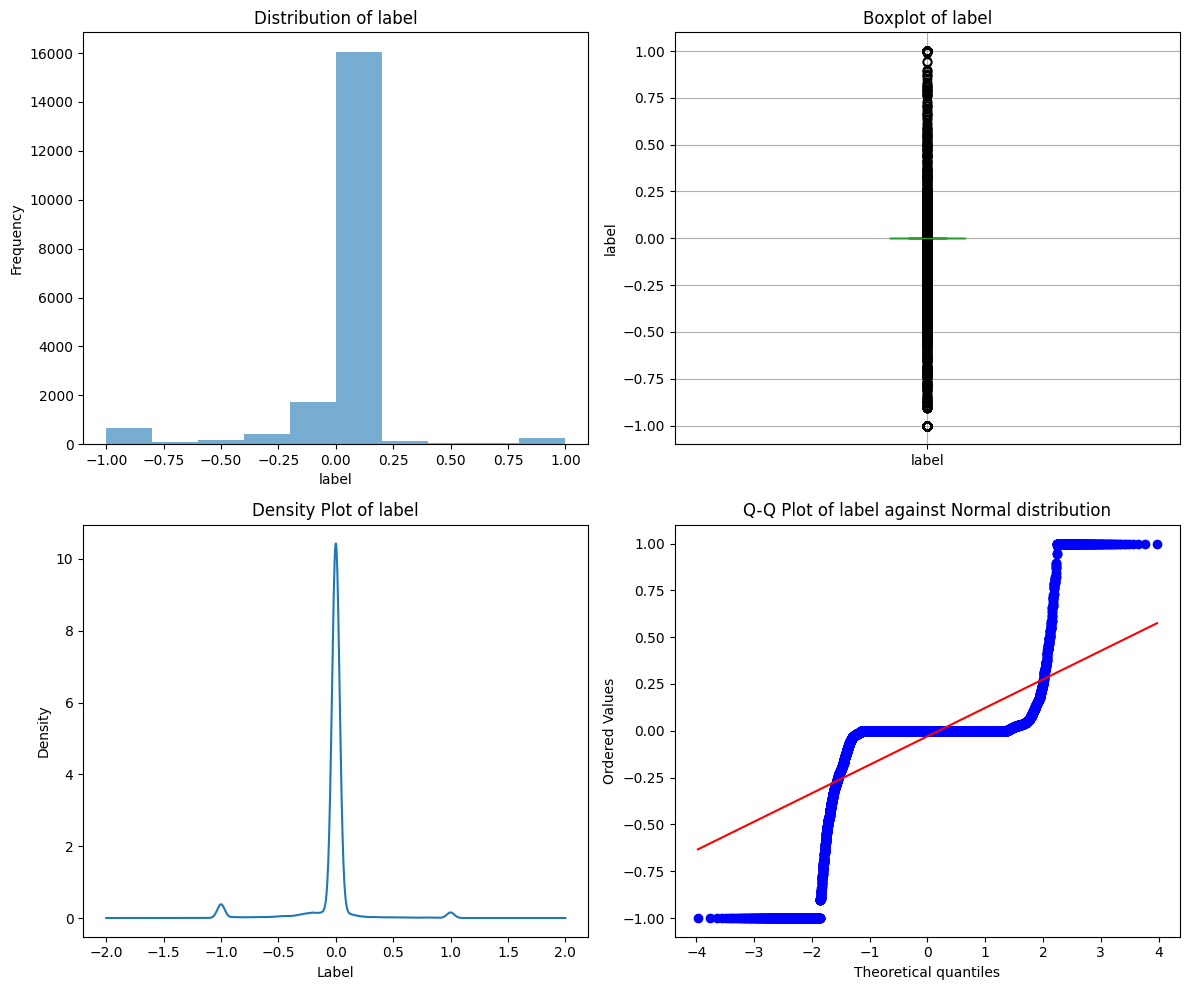

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,1:4] = predicted_trajectory_positions
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,4:7] = predicted_trajectory_orientations


10000
10000
rmse 0.1958868968167058 window size 5 future steps 61
count    17616.000000
mean        -0.012429
std          0.195498
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


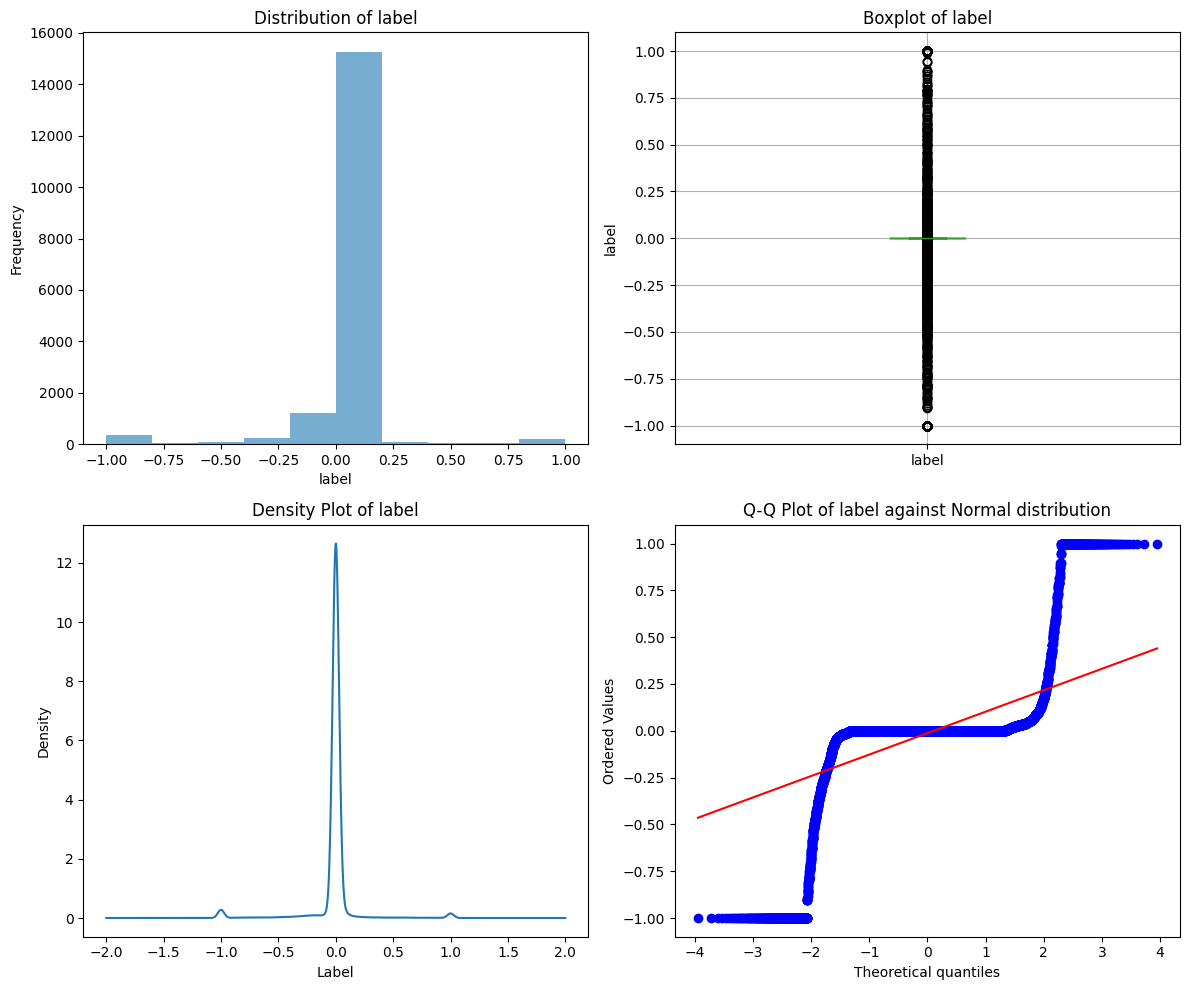

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,1:4] = predicted_trajectory_positions
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,4:7] = predicted_trajectory_orientations


10000
10000
rmse 0.16113683303104823 window size 5 future steps 71
count    15597.000000
mean        -0.007239
std          0.160979
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


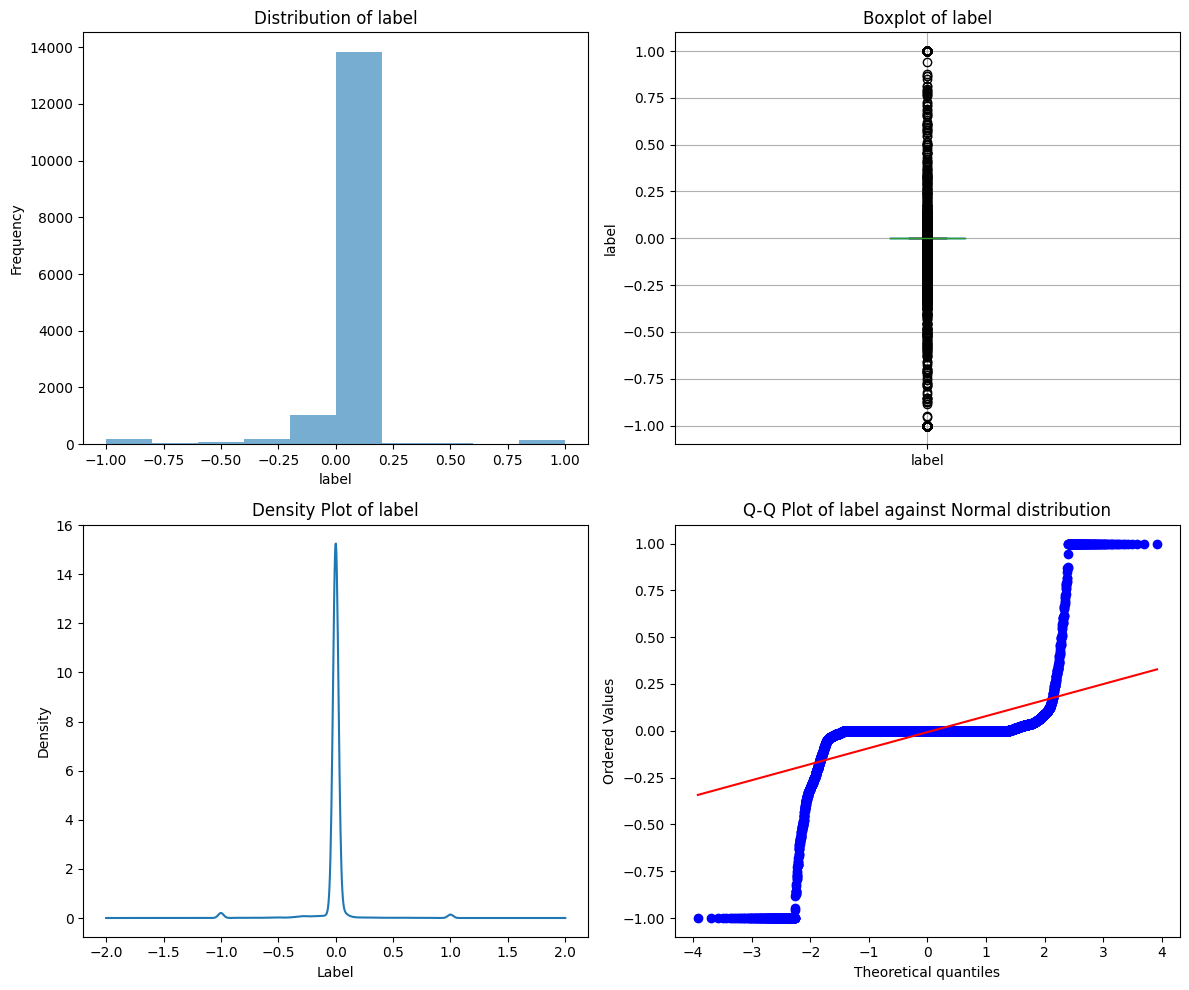

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,1:4] = predicted_trajectory_positions
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,4:7] = predicted_trajectory_orientations


10000
10000
rmse 0.15778729070776906 window size 5 future steps 81
count    13544.000000
mean        -0.010235
std          0.157461
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


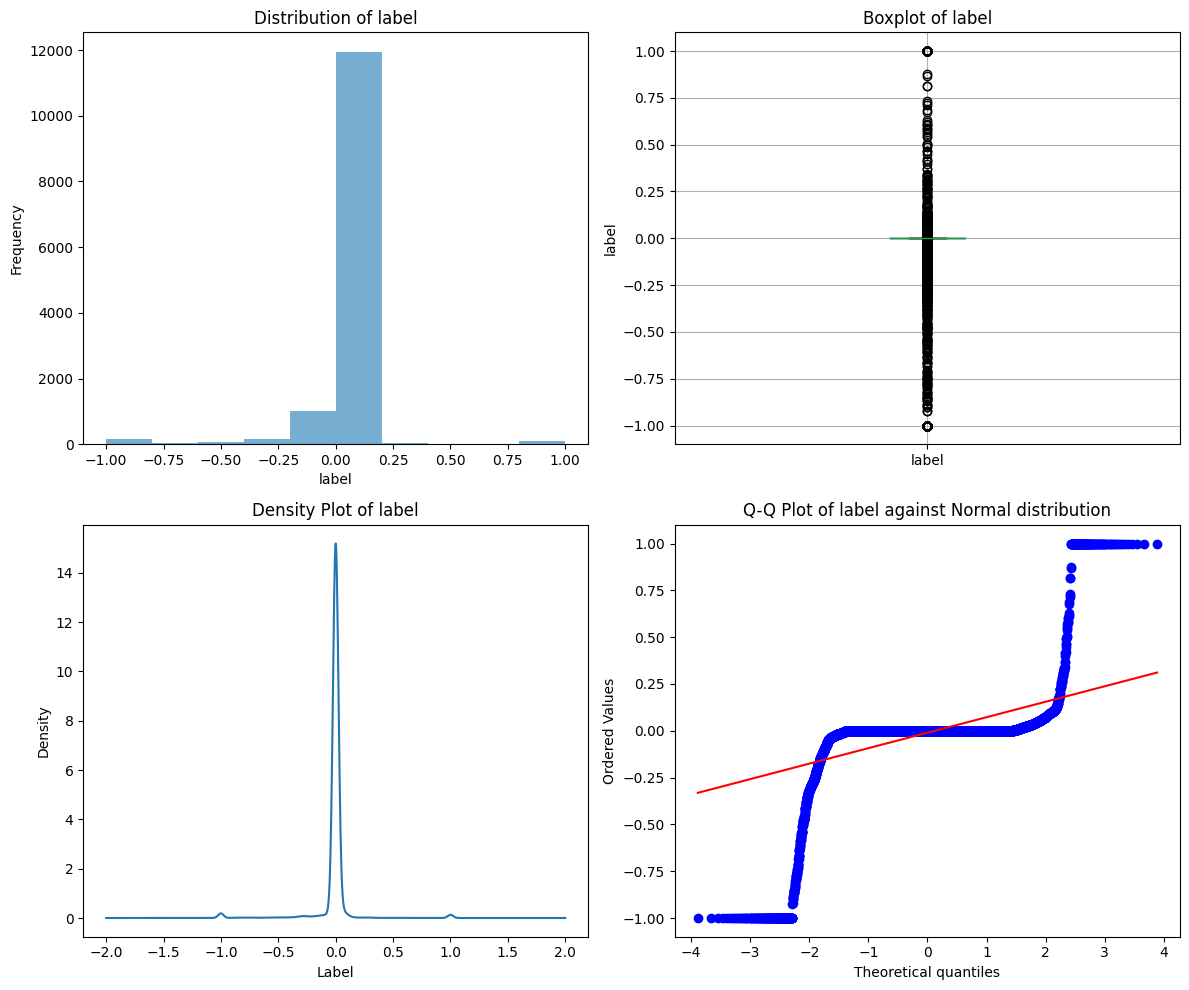

/Users/chenli/research/point cloud/node_feature_utils.py:694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,1:4] = predicted_trajectory_positions
/Users/chenli/research/point cloud/node_feature_utils.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,4:7] = predicted_trajectory_orientations


10000
10000
rmse 0.19198249699997272 window size 5 future steps 91
count    11308.000000
mean        -0.031011
std          0.189470
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


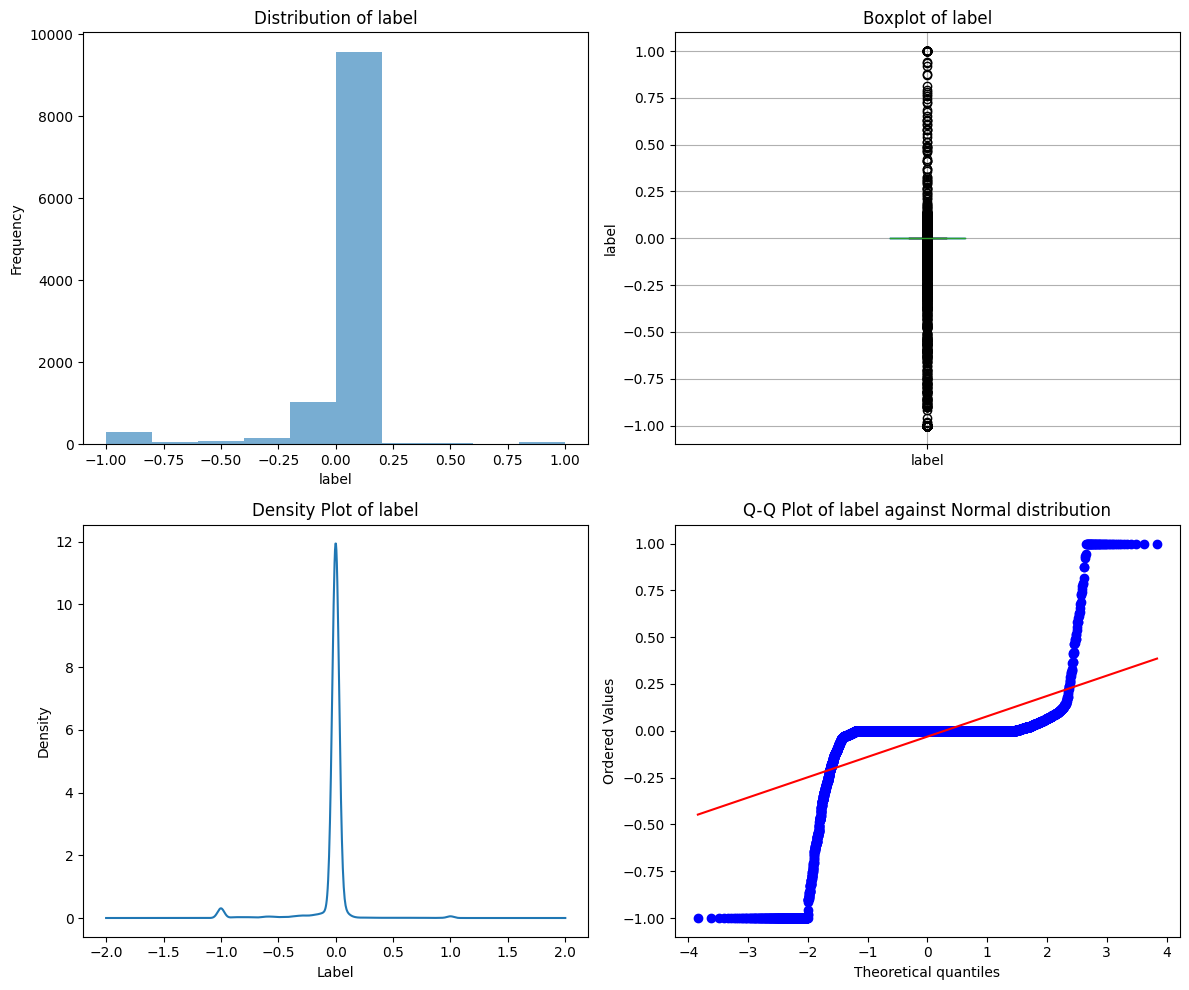

In [649]:
%run node_feature_utils.py
for future_steps in range(1,100,10):
    LR_prediction(window_size_lr=5,future_steps=future_steps)

# one frame distribution

/Users/chenli/research/point cloud/node_feature_utils.py:696: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,1:4] = predicted_trajectory_positions
/Users/chenli/research/point cloud/node_feature_utils.py:697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[0:end_frame_index+1,4:7] = predicted_trajectory_orientations


10000
20000
10000
20000
rmse 0.19676085614530078 window size 5 future steps 20
count    25795.000000
mean        -0.022152
std          0.195514
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64


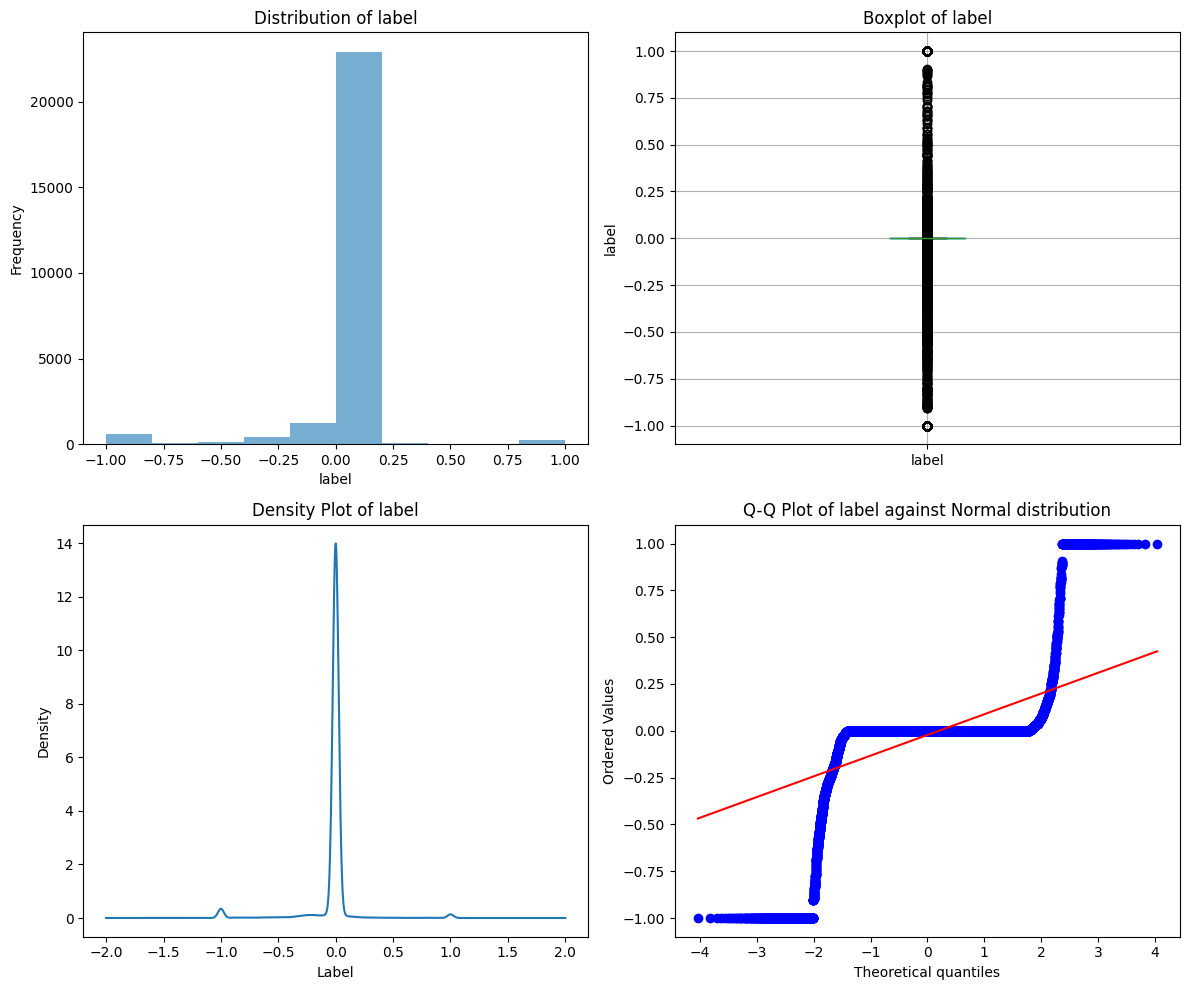

In [658]:
%run node_feature_utils.py
LR_prediction(window_size_lr=5,future_steps=20)

In [651]:
window_size_lr = 5
future_steps = 31
pred_difference_path = "./6DoF-HMD-UserNavigationData-master/NavigationData/H1_nav_pred_difference"+str(window_size_lr)+str(future_steps)+".csv"

In [652]:
diff_df = pd.read_csv(pred_difference_path)

In [653]:
diff_df_one_frame = diff_df[diff_df.ts==145]

,cell,ts,label_gt,label_pred,label
0,"(7, 1, 8)",35,0.014172,0.000000,-0.014172
1,"(6, 7, 6)",35,1.000000,1.000000,0.000000
2,"(7, 12, 8)",35,0.309213,0.309213,0.000000
3,"(8, 6, 9)",35,0.159158,0.159158,0.000000
4,"(8, 8, 6)",35,1.000000,1.000000,0.000000
...,...,...,...,...,...
23638,"(9, 4, 6)",149,0.420809,0.420809,0.000000
23639,"(9, 5, 5)",149,1.000000,1.000000,0.000000
23640,"(6, 12, 8)",149,0.108778,0.108778,0.000000
23641,"(6, 13, 7)",149,0.467607,0.467607,0.000000


In [655]:
diff_df_one_frame = diff_df[diff_df.ts==145]
diff_df_one_frame

,cell,ts,label_gt,label_pred,label
22673,"(5, 12, 6)",145,1.000000e+00,1.000000e+00,0.000000e+00
22674,"(7, 1, 8)",145,3.384737e-01,3.384737e-01,0.000000e+00
22675,"(6, 7, 6)",145,1.000000e+00,1.000000e+00,0.000000e+00
22676,"(7, 12, 8)",145,2.141032e-01,2.141032e-01,0.000000e+00
22677,"(8, 8, 6)",145,1.000000e+00,1.000000e+00,0.000000e+00
...,...,...,...,...,...
22865,"(6, 12, 8)",145,2.180981e-01,2.180981e-01,0.000000e+00
22866,"(7, 7, 9)",145,6.303193e-32,5.703365e-32,-5.998281e-33
22867,"(6, 13, 7)",145,1.000000e+00,1.000000e+00,0.000000e+00
22868,"(8, 12, 10)",145,1.317801e-03,1.317801e-03,0.000000e+00
